# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

## Подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import re

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

### Используемые функции

In [2]:
def snake_case(data_columns):
    """Функция приводящая PascalСase к snake_case"""
    new_columns = []
    for name in data_columns:      
        new_columns.append(re.sub(r"(?<=\w)([A-Z])", r"_\1", name).lower())
    return new_columns

In [3]:
def data_recovery(recovery_column):
    """Восстановление данных в столбце"""
    columns = ['brand','model','vehicle_type','gearbox','power','fuel_type']
    columns.remove(recovery_column)
    
    #создание ключа для словаря
    data_clean['dict_power'] = ''
    data['power_columns'] = ''
    for column in columns:
        data_clean['dict_power'] += data_clean[column].astype(str)
        data['power_columns'] += data[column].astype(str)
        
    #создание словаря
    dictionary = dict(data_clean.groupby('dict_power')[recovery_column].agg(lambda x:x.value_counts(ascending=False).index[0]))

    return data[recovery_column].fillna(data['power_columns'].map(dictionary))

In [4]:
def importance_features(model):
    """Построение графика анализа важности факторов для обученной модели"""
    plt.figure(figsize=(16,5))
    ax = sns.barplot(x=features_train.columns, y=model.feature_importances_)
    ax.set(xlabel='Признак', ylabel='Важность', title='Анализ важности признаков для обучения модели')
    ax.set_xticklabels(features_train.columns, rotation=20, ha='right')
    ax.grid(True)
    return plt.show()

### Изучение данных

In [5]:
data = pd.read_csv('autos.csv', parse_dates=[0,12,15])
data_rows_begin = data.shape[0]
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Приведём названия столбцов к snake_case:

In [6]:
data.columns = snake_case(data.columns)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

`date_crawled` — дата скачивания анкеты из базы<br>
`vehicle_type` — тип автомобильного кузова<br>
`registration_year` — год регистрации автомобиля<br>
`gearbox` — тип коробки передач<br>
`power` — мощность (л. с.)<br>
`model` — модель автомобиля<br>
`kilometer` — пробег (км)<br>
`registration_month` — месяц регистрации автомобиля<br>
`fuel_type` — тип топлива<br>
`brand` — марка автомобиля<br>
`not_repaired` — была машина в ремонте или нет<br>
`date_created` — дата создания анкеты<br>
`number_of_pictures` — количество фотографий автомобиля<br>
`postal_code` — почтовый индекс владельца анкеты (пользователя)<br>
`last_seen` — дата последней активности пользователя<br>
`price` — цена (евро)<br>

У нас в распоряжении датасет размером (354369, 16), в котором присутствуют пропущенные значения в следующих столбцах:

* vehicle_type
* gearbox
* model
* fuel_type
* not_repaired

Рассмотрим данные на наличие аномалий:

In [8]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


1. `registration_year` - сразу видны несколько аномальных значений, максимальный и минимальный годы 9999 и 1000. Следует проверить, какой диапазон годов в нашем распоряжении.
2. `power` - 20000 лошадиных сил в максимальном значении, 0 в минимальном. Врядли кто-то продавал боинги через сервис по продаже автомобилей.

3. `number_of_pictures` - все значения нулевые. Считаем, что бесполезный для обучения столбец, так как наличие фотографий, их количество и качество скорее повлияют на скорость продажи, чем на цену автомобиля.

### Предобработка данных

Начнём с удаления аномалий в столбце `registration_year`. Год постановки на учёт по имеющимся у нас данным определить с высокой точностью мы не можем, максимум - определить диапазон, в зависимости от года выпуска модели. Так же, можем предположить, что это год регистрации автомобиля в отделе дорожной полиции последним владельцем после покупки, например, а не год выпуска автомобиля с завода.

Также, нам неизвестно, будут ли пользоваться этим сервисом хозяины ретро-автомобилей. Такие, вероятно скорее обратятся к коллекционерам на специальные площадки, занимающиеся ретро-автомобилями. Согласно Википедиии, в США автомобиль считается ретро если выпущен за 20 и более лет до текущей даты, в Германии - 30 лет, а в России точное официальное определение и вовсе отсутствует.

Так что примем, что учить модель будем на данных с `registration_year` с 1970 по 2016 годы (50 лет), считая, что оценка ретро-автомобилей всё таки намного более сложная задача, зависящая от куда более большого количества признаков. 2016 год считаем крайним, т.к. это год создания анкет.

In [9]:
data = data.query('1950 <= registration_year <= 2016')

Перейдём к `power`. Такие данные можно восстанавливать, опираясь на уже имеющуюся информацию.

Создадим копию нашего датасета, но в отличии от исходного удалим отуда все неизвестные значения.

In [10]:
clean_columns = ['brand','model','vehicle_type','gearbox','power','fuel_type']
data_clean = data[clean_columns].copy().dropna()

На основе `data_clean` мы сможем создавать необходимые словари для заполнения данных. Созданим такой для `power`.

In [11]:
data_clean['dict_power'] = data_clean['brand']+data_clean['model']+data_clean['vehicle_type']+data_clean['gearbox']+data_clean['fuel_type']

In [12]:
data_clean.head(5)

,brand,model,vehicle_type,gearbox,power,fuel_type,dict_power
2,jeep,grand,suv,auto,163,gasoline,jeepgrandsuvautogasoline
3,volkswagen,golf,small,manual,75,petrol,volkswagengolfsmallmanualpetrol
4,skoda,fabia,small,manual,69,gasoline,skodafabiasmallmanualgasoline
5,bmw,3er,sedan,manual,102,petrol,bmw3ersedanmanualpetrol
6,peugeot,2_reihe,convertible,manual,109,petrol,peugeot2_reiheconvertiblemanualpetrol


Да, такой набор букв (можно, конечно и пробелами разделить, но в данном случае это не важно) и будет являться ключём для восстановления данных. Создадим словарь, так как значений для одного набора данных может быть несколько - отсортируем по популярности и добавим в словарь самый часто встречающийся вариант.

In [13]:
power_dict = data_clean.groupby('dict_power')['power'].agg(lambda x:x.value_counts(ascending=False).index[0])
power_dict = dict(power_dict[power_dict > 0])

Теперь определим, какие именно значения мы будем заменять. Что считать слишком большой мощностью, а что - в рамках дозволенности? Например, не будем трогать `power` со значением 0. Может, хозяин этой машины по какой либо причине снял двигатель? Рассмотрим верхний край дозволенных значений через ящик с усами:

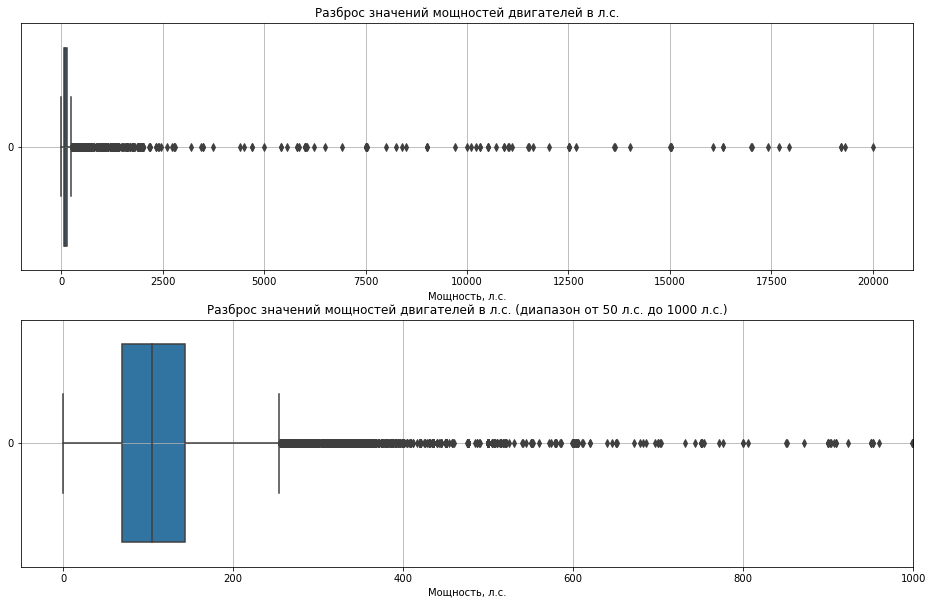

In [14]:
f, (ax1, ax2) = plt.subplots(2,1)
sns.boxplot(data=data['power'], orient='horizontal', ax=ax1)
ax1.set(xlabel='Мощность, л.с.', title='Разброс значений мощностей двигателей в л.с.')
ax1.grid(True)
sns.boxplot(data=data['power'], orient='horizontal', ax=ax2)
ax2.set(xlabel='Мощность, л.с.', xlim=(-50,1000),\
        title='Разброс значений мощностей двигателей в л.с. (диапазон от 50 л.с. до 1000 л.с.)')
ax2.grid(True)
f.set_figwidth(16)
f.set_figheight(10)

Верхние значения могут доходить до 20000 л.с., а вот основная масса лежит в пределах 400-500 лошадиных сил. Попробуем заменить только значения, превышающие 500 л.с., а от остальных избавимся.

In [15]:
data['power_columns'] = data['brand']+data['model']+data['vehicle_type']+data['gearbox']+data['fuel_type']

In [16]:
max_power = 500
data.loc[data['power']>max_power,'power'] = np.nan
data.loc[:,'power'] = data['power'].fillna(data['power_columns'].map(power_dict))
data = data[data['power']<=max_power].reset_index(drop=True)
data['power'] = data['power'].astype(int)

Для того, чтобы избежать ошибок в наименованиях (например, "range_rover" и "rangerover"), уберём все знаки подчёркивания.

In [17]:
data.loc[:,'model'] = data['model'].replace(r'[_]','', regex=True)

Теперь приступим к заполнению пропущенных значений в `vehicle_type`, `gearbox`, `model`, `fuel_type`. Будем использовать тот же способ, что и для `power`.

In [18]:
vehicle_type = data['vehicle_type'].isna().sum()
gearbox = data['gearbox'].isna().sum()
model = data['model'].isna().sum()
fuel_type = data['fuel_type'].isna().sum()

In [19]:
%%time
for column in ['vehicle_type','gearbox','model','fuel_type']:
    data.loc[:,column] = data_recovery(column)
data = data.drop(columns='power_columns')

Wall time: 1min 38s


In [20]:
print('Восстановлено значений:')
print(f'vehicle_type: {vehicle_type - data["vehicle_type"].isna().sum()}')
print(f'gearbox: {gearbox - data["gearbox"].isna().sum()}')
print(f'model: {model - data["model"].isna().sum()}')
print(f'fuel_type: {fuel_type - data["fuel_type"].isna().sum()}')

Восстановлено значений:
vehicle_type: 7059
gearbox: 6057
model: 7003
fuel_type: 9392


С `not_repaired` поступим следующим образом: введём для него новое значение - unknown, так как неизвестно был ремонт или нет, а восстановить их никак нельзя.

In [21]:
data.loc[:,'not_repaired'] = data['not_repaired'].fillna('unknown')

Теперь рассмотрим `price`. Там существуют нулевые цены, то есть, мы не знаем что именно хотел хозяин автомобиля - избавиться от него, чтобы не оплачивать утилизацию или просто побыстрее отдать автомобиль. Модель может неправильно понять нулевую цену (а это наш целевой признак), поэтому считаем целесообразным удалить все строки с нулевой ценой.

In [22]:
data.loc[:,:] = data[data['price']>0]

Остальные пропущенные значения мы удалим.

In [23]:
data = data.dropna().reset_index(drop=True)
print(f'Размер датасета {data.shape}. Удалено {round((data_rows_begin-data.shape[0])/data_rows_begin*100,2)}% строк.')

Размер датасета (306786, 16). Удалено 13.43% строк.


По итогам предобработки данных нам удалось восстановить некоторое количество данных, при этом мы потеряли всего лишь 11.76% данных. Также при необходимости можно все пропущенные значения в категориальных переменных заменить на `unknown`, но это может перегрузить модель и негативно отразиться на качестве предсказаний.

In [24]:
del data_clean

### Подготовка данных

Подготовим данные для обучения модели. Выделим признаки и целевой признак в отдельные переменные, разобьём категориальные переменные и масштабируем количественные.

В качестве признаков для обучения модели выберем следующие:
* vehicle_type
* registration_year
* gearbox
* power
* model
* kilometer
* fuel_type
* brand
* not_repaired

In [25]:
features = data[['vehicle_type', 'registration_year', 'gearbox','power', 'model', 'kilometer', 'fuel_type', 'brand',
                 'not_repaired']]
target = data['price']

Категориальные переменные будем преобразовывать с помощью порядкового кодирования, из-за того, что например в `vehicle_type` или `model` с помощью метода "OHE" получится огромное количество столбцов. `postal_code`, не смотря на то, что состоит из чисел, тоже является категориальной переменной - это привязка к месту продажи, почтовый индекс.

In [26]:
encoder = OrdinalEncoder()

In [27]:
columns_oe = ['vehicle_type', 'model', 'brand']
categorial_columns = features[columns_oe]
features[columns_oe] = pd.DataFrame(encoder.fit_transform(features[columns_oe]), columns=categorial_columns.columns)

Столбцы `vehicle_type`, `gearbox`, `fuel_type` и `not_repaired` закодируем с помощью прямого кодирования.

In [28]:
columns_ohe = ['gearbox','fuel_type','not_repaired']
ohe_columns = features[columns_ohe]
features_ohe = pd.get_dummies(features[columns_ohe], drop_first=True)

Объединим признаки с порядковым значением с признаками с прямым кодированием.

In [29]:
features = features.drop(columns=columns_ohe)
features = features.join(features_ohe)

Теперь разделим на обучающую и валидационную выборки:

In [30]:
r = 42
features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=r, test_size=.25)

И после разделения масштабируем признаки `registration_year`,`power`,`kilometer`

In [31]:
scaled_columns = ['registration_year','power','kilometer']
scaler = StandardScaler()
scaler.fit(features_train[scaled_columns])
features_train.loc[:, scaled_columns] = scaler.transform(features_train[scaled_columns])
features_valid.loc[:, scaled_columns] = scaler.transform(features_valid[scaled_columns])

In [32]:
features_train.head()

,vehicle_type,registration_year,power,model,kilometer,brand,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,not_repaired_unknown,not_repaired_yes
173567,7.0,-0.101143,0.321943,35.0,0.582652,1.0,1,0,0,0,0,0,1,0,0
214778,7.0,-0.101143,0.637294,187.0,0.582652,37.0,1,0,1,0,0,0,0,0,0
286389,4.0,-0.419026,0.969242,19.0,0.582652,2.0,1,0,0,0,0,0,1,0,0
190661,5.0,0.534623,-0.225773,44.0,-0.100982,23.0,1,0,0,0,0,0,1,0,1
229536,7.0,-0.736909,-0.358552,187.0,0.582652,37.0,1,0,1,0,0,0,0,0,0


Теперь наши данные готовы к обучению.

## Обучение моделей

Попробуем несколько моделей: случайный лес в регрессии и линейную регрессию. В роли метрики возьмём RMSE - квадратный корень из средней квадратичной ошибки.

### Дерево решений

In [33]:
%%time
dt = DecisionTreeRegressor(max_depth=21, min_samples_split=8, min_samples_leaf=4, random_state=r)
dt.fit(features_train, target_train)
predictions_valid = dt.predict(features_valid)
rmse_dt = round(mean_squared_error(predictions_valid, target_valid)**.5,2)
print(f'RMSE Дерева решений в регрессии: {rmse_dt}')

RMSE Дерева решений в регрессии: 1734.64
Wall time: 1.46 s


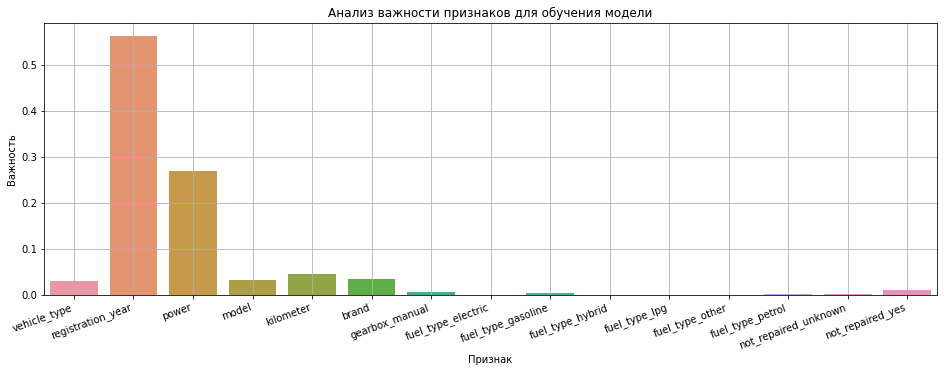

In [34]:
importance_features(dt)

### Случайный лес

In [35]:
%%time
rfr = RandomForestRegressor(n_estimators=51, max_depth=25,  min_samples_split=8, random_state=r)
rfr.fit(features_train, target_train)
predictions_valid = rfr.predict(features_valid)
rmse_rfr = round(mean_squared_error(predictions_valid, target_valid)**.5,2)
print(f'RMSE Случайного леса в регрессии: {rmse_rfr}')

RMSE Случайного леса в регрессии: 1551.44
Wall time: 56.3 s


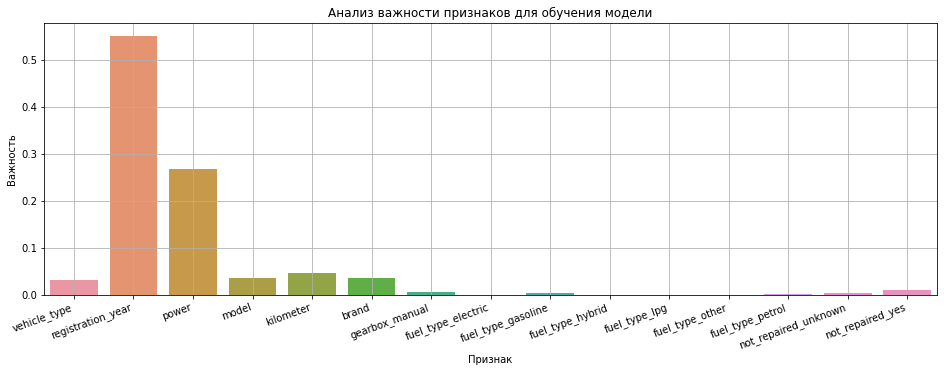

In [36]:
importance_features(rfr)

### Линейная регрессия

In [37]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train)
predictions_valid = lr.predict(features_valid)
rmse_lr = round(mean_squared_error(predictions_valid, target_valid)**.5,2)
print(f'RMSE Линейной регрессии: {rmse_lr}')

RMSE Линейной регрессии: 2990.35
Wall time: 384 ms


### Сравнение с константной моделью

Сравним RMSE, полученые от трёх моделей с константной моделью, где все значения будут равны среднему.

In [40]:
predictions_fict = pd.Series(target_valid.mean(), index=target_valid.index)
rmse_fict = round(mean_squared_error(predictions_fict, target_valid)**.5,2)
print(f'RMSE константной модели: {rmse_fict}')

RMSE константной модели: 4563.9


## Анализ моделей

Проанализируем время затраченное за подбор гиперпараметров, обучение моделей и полученные RMSE:

In [41]:
analysis = [['Дерево решений', rmse_dt],
            ['Случайный лес', rmse_rfr],
            ['Линейная регрессия', rmse_lr],
            ['Константная модель', rmse_fict]]
columns = ['Модель','RMSE']
analysis_data = pd.DataFrame(data=analysis, columns=columns)
analysis_data.sort_values(by='RMSE', axis=0).reset_index(drop=True)

,Модель,RMSE
0,Случайный лес,1551.44
1,Дерево решений,1734.64
2,Линейная регрессия,2990.35
3,Константная модель,4563.90


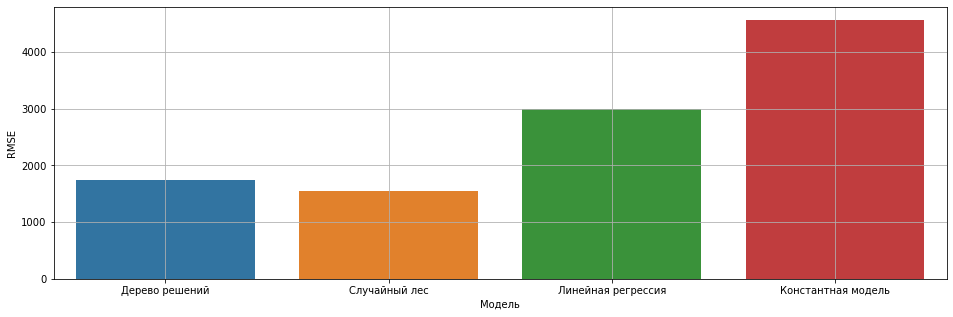

In [45]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x=analysis_data['Модель'], y=analysis_data['RMSE'])
ax.grid(True)
plt.show()

Все модели прошли проверку с константной моделью. Линейная регрессия хороша скоростью, но среднее отклонение составляет почти в 3000 евро. При этом у дерева решений и случайного леса гораздо лучше результат (отклонение порядка 1500 евро), но при этом время обучения и предсказания значений уступают скорости линейной регрессии.

Проанализировав важность признаков для обучения модели видно, что двумя важнейшими признаками для обучения являются год регистрации автомобиля и мощность (чем новее и мощнее машина - тем дороже). Отсюда можем сделать вывод, что модель можно улучшить, привнеся новые признаки, например, категоризацию по году регистрации и по мощности.